In [1]:
%pylab inline

from easy_plot import easy_plot

import scipy.ndimage as ndi
from scipy.signal import fftconvolve

%load_ext autoreload
%autoreload 2
from pyotf.otf import SheppardPSF, HanserPSF
from pyotf.utils import easy_fft, easy_ifft
import dphtools.display as dplt
from dphtools.utils import bin_ndarray

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.set_cmap("inferno");

<Figure size 640x480 with 0 Axes>

## Point Scanning

For any type of fluorescence microscopy technique the total point spread function (PSF) can be expressed as the multiplication of the _excitation_ PSF, $PSF_{exc}$, and the _detection_ PSF, $PSF_{det}$. Both PSFs are _intensity_ PSFs because fluorophores respond to the intensity of the field not the field itself and all detectors are square law detectors meaning they also respond to intensity and not field.

$$
PSF_{total} = PSF_{exc} \times PSF_{det}
$$

For a perfect confocal microscope, i.e. one with an infinitesimal pinhole (or various flavors of photon reassignment microscopy which act in much the same way with infinitely better efficiency), $PSF_{exc}$ and $PSF_{det}$ are simply widefield PSFs at the excitation and detection wavelengths.

We'll start with this.

In [3]:
# We'll use a 1.27 NA water dipping objective imaging in water
psf_params = dict(na=1.27, ni=1.33, wl=0.561, size=128, vec_corr="none")

# Set the Nyquist sampling rate
nyquist_sampling = psf_params["wl"] / psf_params["na"] / 4

# our oversampling factor, must be odd for easy integration (for peaked symmetrical funtions
# the kernel must be odd) increase this to have a more accurate simulation
oversample_factor = 1

# we need to be at half nyquist because, for the perfect confocal/airyscan/ISM, we'll get a factor of 2 improvement in OTF cutoff
psf_params["res"] = nyquist_sampling / oversample_factor / 2
psf_params["size"] *= oversample_factor

In [4]:
# calculate 3D
psf_exc = SheppardPSF(**psf_params).PSFi
psf_params["wl"] = 0.585
psf_det = SheppardPSF(**psf_params).PSFi

In [5]:
# total PSF is multiplication of excitation and emission
psf_con = psf_exc * psf_det

<Figure size 900x1200 with 24 Axes>

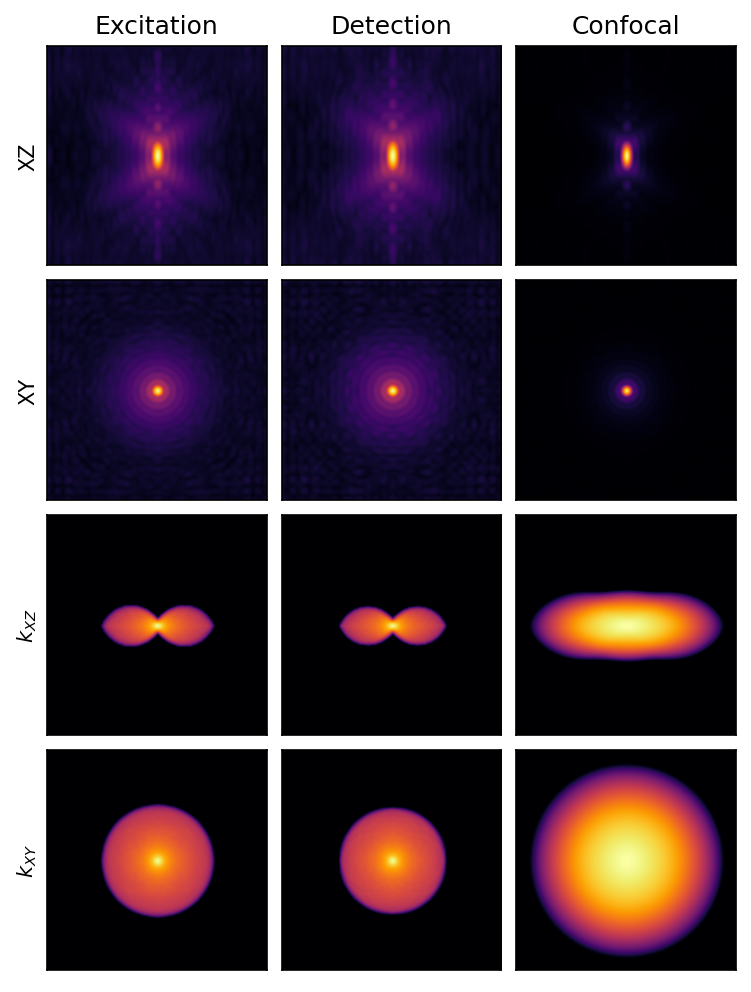

<Figure size 900x600 with 1 Axes>

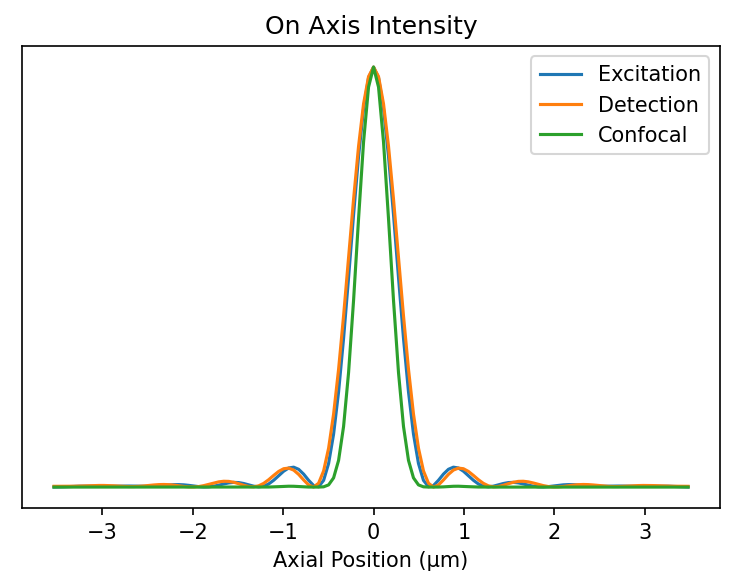

In [6]:
labels = "Excitation", "Detection", "Confocal"
psfs = psf_exc, psf_det, psf_con
easy_plot(psfs, labels, oversample_factor, res=psf_params["res"])

### Different pinhole sizes

When speaking about confocal pinholes we usual work in what's called _Airy Units_ or _AU_. One AU is equivalent to the diamter of the first airy ring, which is defined as the first minimum in the airy function. That means that

$$
AU = 1.22 \frac{\lambda}{NA}
$$

Modeling the effects of the pinhole are actually quite simple: we just need to convolve the detection PSF in the lateral plane with the pinhole transmission function, which in the simplest (and most reasonable case) is simply a ciruclar top hat function. Why convolution? If you were to image a single point emitter perfectly aligned with the excitation PSF then you'd just multiply by the pinhole and integrate. But what if your emitter is off-axis? Then it's image is also off axis etc.

In [7]:
# define airy units in terms of pixels
airy_unit = 1.22 * psf_params["wl"] / psf_params["na"] / psf_params["res"]
airy_unit

10.17754010695187

In [8]:
def disk_kernel(radius):
    full_size = int(np.ceil(radius * 2))
    if full_size % 2 == 0:
        full_size += 1
    coords = np.indices((full_size, full_size)) - (full_size - 1) // 2
    r = np.sqrt((coords**2).sum(0))
    kernel = r < radius
    return kernel / kernel.sum()

In [9]:
kernel = disk_kernel(1 * airy_unit / 2)
psf_det_au1 = fftconvolve(psf_det, kernel[None], "same", axes=(1, 2))
psf_con_au1 = psf_det_au1 * psf_exc

<Figure size 900x1200 with 24 Axes>

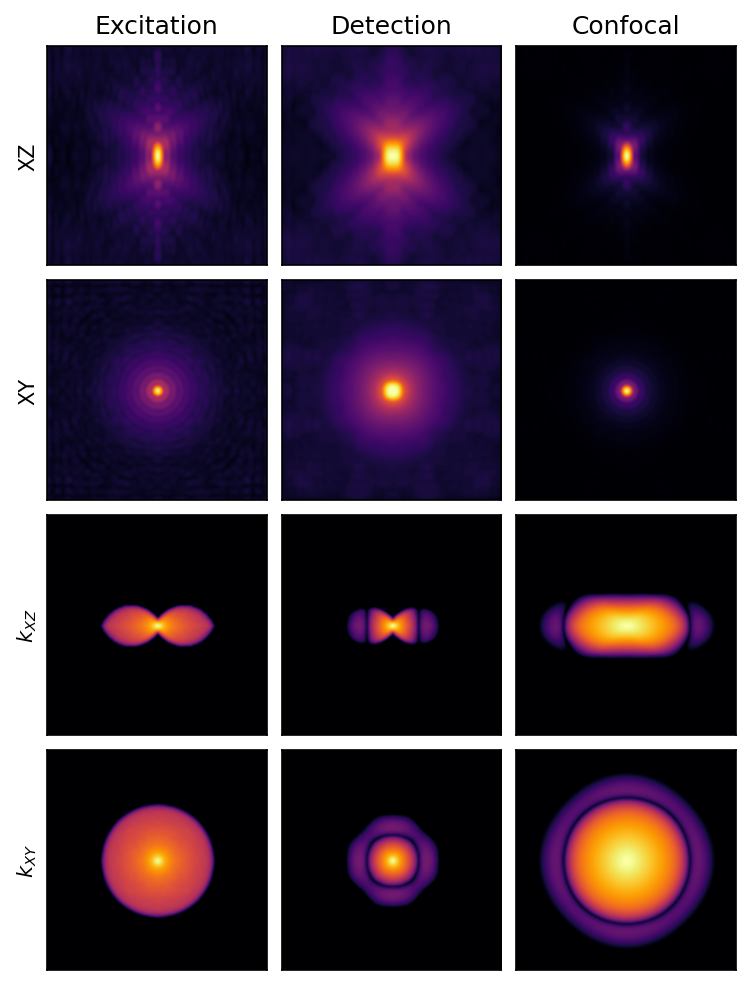

<Figure size 900x600 with 1 Axes>

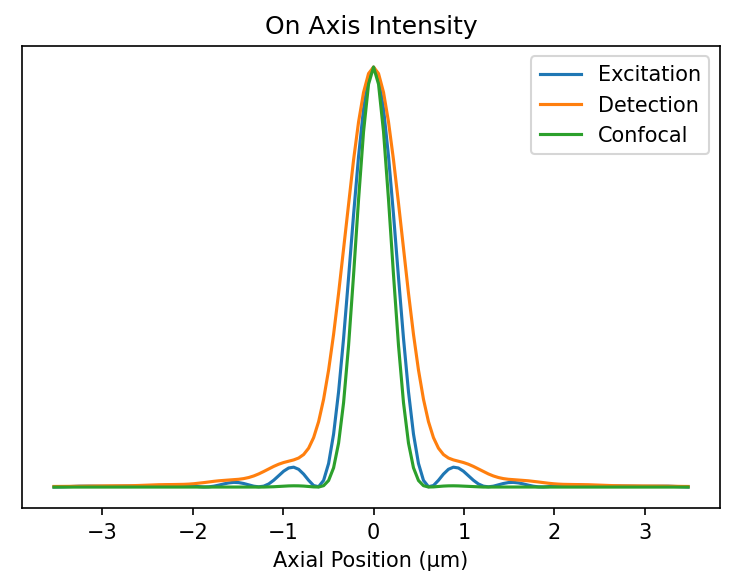

In [10]:
easy_plot((psf_exc, psf_det_au1, psf_con_au1), labels, oversample_factor, psf_params["res"])

In [11]:
# now lets try 10 AU, 1 AU and 0.1 AU
psf_au = []
label_au = []
for au in (0.1, 1, 2, 10):

    kernel = disk_kernel(au * airy_unit / 2)
    psf_det_au = fftconvolve(psf_det, kernel[None], "same", axes=(1, 2))

    psf_au.append(psf_det_au * psf_exc)
    label_au.append(f"{au:} AU")

<Figure size 1500x1200 with 40 Axes>

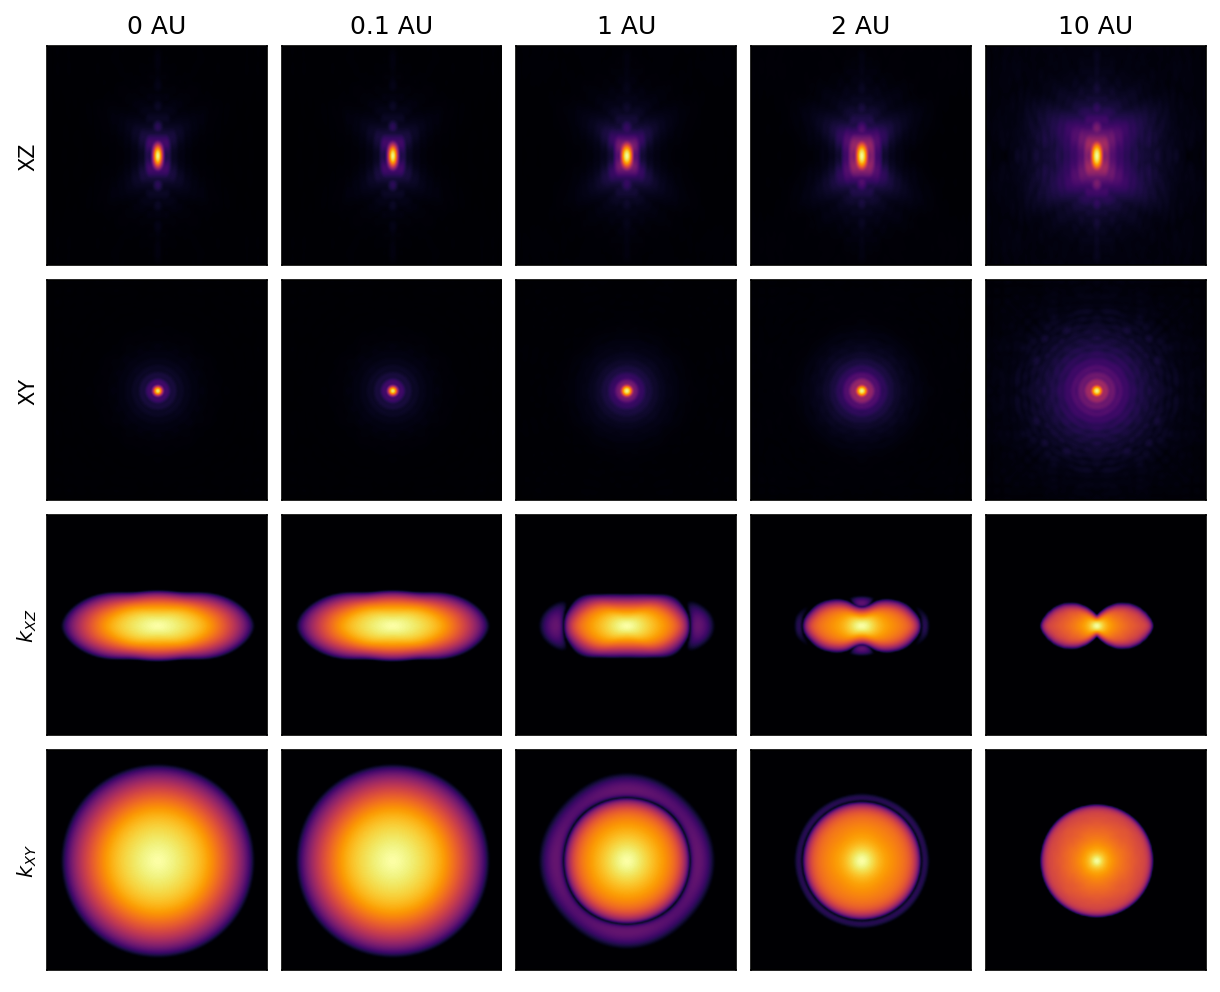

<Figure size 1500x600 with 1 Axes>

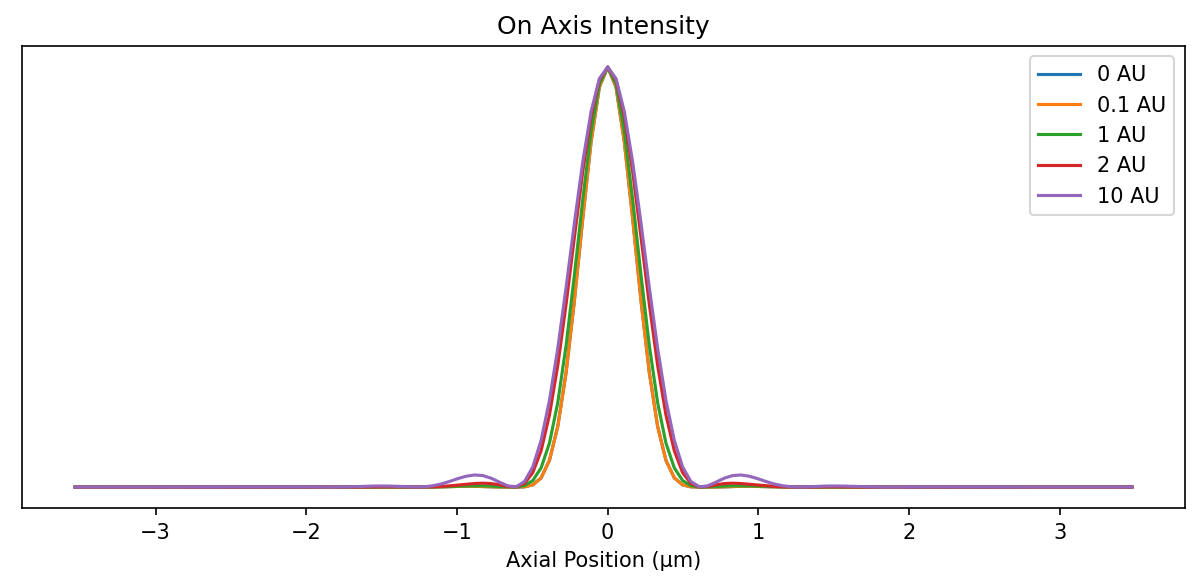

In [12]:
easy_plot([psf_con] + psf_au, ["0 AU"] + label_au, oversample_factor, psf_params["res"])

In [36]:
disk_kernel(1.01)

array([[0. , 0.2, 0. ],
       [0.2, 0.2, 0.2],
       [0. , 0.2, 0. ]])

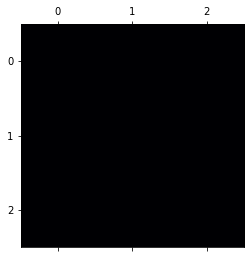

In [31]:
matshow(disk_kernel(1.5))

## Spinning Disk Confocal

This should be the same as the point scanning confocal except the detection PSF needs to be convolved with _both_ the pinhole _and_ the camera pixel.